In [1]:
import matplotlib.pyplot as plt
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import nibabel as nib
from scipy import ndimage
import glob
import sys,os
from natsort import natsorted
import tensorflow_probability as tfp
import random
from aifnet_utils.preprocess import read_nifti_file, normalize, normalize_aif, process_scan, normalize_zero_one
from aifnet_utils.losses import MaxCorrelation
from aifnet_utils.data_loaders import read_isles_annotations, read_isles_volumes, ISLES18DataGen_aifvof_aug
from aifnet_utils.data_loaders import delay_sequence_padding, anticipate_sequence_padding, late_bolus, early_bolus
%matplotlib inline

In [2]:
!pwd

/home/sebastian/experiments/aifnet_replication


In [3]:
keras.backend.set_image_data_format('channels_last')

In [4]:
root_dir     = '/media/sebastian/data/ASAP/ISLES2018_Training'
#At insel: /media/sebastian/data/ASAP/ISLES2018_Training
#Local: '/Users/sebastianotalora/work/postdoc/data/ISLES/'
aif_annotations_path = '/home/sebastian/experiments/aifnet_replication/annotated_aif_vof_complete_revised.csv'
min_num_volumes_ctp = 43
ROOT_EXP = '/home/sebastian/experiments/aifnet_replication'#'/Users/sebastianotalora/work/postdoc/ctp/aifnet_replication'


In [5]:
aif_annotations, vof_annotations = read_isles_annotations(aif_annotations_path, root_dir, 
                                         min_num_volumes_ctp, return_aif_only = False)

In [6]:
ctp_volumes = read_isles_volumes(root_dir, aif_annotations_path, min_num_volumes_ctp, take_two_slices_only=False)

In [7]:
print(len(ctp_volumes), len(aif_annotations))

94 94


In [8]:
def get_model_twoPvols(width=256, height=256, num_channels=43):
    """Build a 3D convolutional neural network model."""
    #width and height of the PCT is 256, the number of slices is variable, and the number of channels are
    #the number of timepoints in the PCT sequence        
    inputs = keras.Input((width, height, None , 43))

    x = layers.Conv3D(filters=16, kernel_size=(3,3,1), activation="relu", data_format='channels_last', padding='same')(inputs)
    #x = layers.Dropout(0.3)(x)
    
    x = layers.Conv3D(filters=32, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)
    #x = layers.Dropout(0.3)(x)
    
    x = layers.Conv3D(filters=64, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)
    #x = layers.Dropout(0.3)(x)
    
    x = layers.Conv3D(filters=128, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)

    #x = layers.Conv3D(filters=256, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)
    #x = layers.Dropout(0.3)(x)
    Lout = layers.Conv3D(filters=1, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)
    Lout2 = layers.Conv3D(filters=1, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)

    P_vol_aif = tf.keras.activations.sigmoid(Lout,name="aif")
    P_vol_vof = tf.keras.activations.sigmoid(Lout2,name="vof")
    #Voxelwise multiplication of P_vol and each of the CTP time points    
    voxelwise_mult_each_ctp_aif = tf.keras.layers.Multiply()([inputs,P_vol_aif])    
    voxelwise_mult_each_ctp_vof = tf.keras.layers.Multiply()([inputs,P_vol_vof])        
    #The 3D average pooling block averages the volumetric information along the x-y-z axes, 
    #such that the predicted vascular function y(t) is a 1D vector of length T.
    outputs_aif = layers.GlobalAveragePooling3D(data_format='channels_last', name='aif_loss')(voxelwise_mult_each_ctp_aif)
    outputs_vof = layers.GlobalAveragePooling3D(data_format='channels_last', name='vof_loss')(voxelwise_mult_each_ctp_vof)    
    #outputs_aif = tf.keras.activations.linear

    # Define the model.
    model = keras.Model(inputs, [outputs_aif,outputs_vof], name="aifnet")
    return model

In [10]:
tf.keras.activations.linear?

In [9]:
# Build model.
model = get_model_twoPvols(width=256, height=256, num_channels=43)
model.summary()

Model: "aifnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, No 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 256, 256, Non 6208        input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 256, 256, Non 13856       conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 256, 256, Non 55360       conv3d_1[0][0]                   
_____________________________________________________________________________________________

In [18]:
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.96, staircase=True
)

In [11]:
optimizer_aifnet = optimizer = keras.optimizers.SGD(learning_rate=lr_schedule) #keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(
    loss=['mse','mse'],
    optimizer=optimizer_aifnet,
    metrics=['mae'])

In [12]:
# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "aif_onehead_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="train_acc", patience=15)
path_checkpointer_model = ROOT_EXP +'/results/' 
path_checkpointer_model += 'aifnet_2Pvols_augment' + str(initial_learning_rate)  + '.hdf5'
path_tensorboard_log    = ROOT_EXP + '/results/logsTensorBoard/'
path_tensorboard_log    += 'aifnet_2Pvols_augment' + str(initial_learning_rate) 

checkpointer = ModelCheckpoint(filepath=path_checkpointer_model, monitor='train_mse', 
                               verbose=1, save_best_only=True)
tb_callback = TensorBoard(log_dir=path_tensorboard_log, histogram_freq=0, write_graph=True, write_grads=False,
                          write_images=False, embeddings_freq=0, embeddings_layer_names=None,
                          embeddings_metadata=None)


In [13]:
train_datagen = ISLES18DataGen_aifvof_aug(ctp_volumes=ctp_volumes, annotations_aif=aif_annotations,
                               annotations_vof=vof_annotations,minimum_number_volumes_ctp = 43, batch_size=1,
                                         time_arrival_augmentation = True)

In [14]:
y = np.array(train_datagen.__getitem__(0)[1])
y

array([[0.08257481, 0.07730358, 0.11813583, 0.        , 0.05550066,
        0.06830165, 0.04794057, 0.09128157, 0.221726  , 0.23537673,
        0.48170579, 0.78750786, 0.86563477, 0.96241198, 1.        ,
        0.99544322, 0.99889876, 0.96218275, 0.86189626, 0.65192204,
        0.56970011, 0.50125448, 0.45215097, 0.39599262, 0.31808581,
        0.29166209, 0.26091968, 0.22856351, 0.26744796, 0.15474904,
        0.14516063, 0.19553963, 0.19290133, 0.14361789, 0.14484713,
        0.16653791, 0.16653791, 0.16653791, 0.16653791, 0.16653791,
        0.16653791, 0.16653791, 0.16653791],
       [0.05415246, 0.02504378, 0.03393869, 0.        , 0.00204326,
        0.02643459, 0.10194071, 0.05102015, 0.07753443, 0.16451013,
        0.28472336, 0.45433134, 0.58080454, 0.78210145, 0.85873841,
        0.85581729, 0.99849415, 1.        , 0.9553362 , 0.82155794,
        0.79300284, 0.69930386, 0.59995823, 0.42033167, 0.37742713,
        0.33015648, 0.28088619, 0.20560513, 0.20963086, 0.18939432,
   

In [15]:
sample_item = 69
x = np.array(train_datagen.__getitem__(sample_item)[0])
#x=x[np.newaxis,:,:,:,:]
y = np.array(train_datagen.__getitem__(sample_item)[1])
y = y[np.newaxis,:]
print(y.shape)
print(x.shape)
print(y)

(1, 2, 43)
(1, 256, 256, 2, 43)
[[[0.         0.         0.         0.         0.         0.
   0.         0.123592   0.17131565 0.19008231 0.2277082  0.17284587
   0.21105302 0.26207688 0.22799301 0.45720455 0.4913874  0.49300343
   0.70448294 0.88714153 0.98140581 0.98507468 0.89363239 1.
   0.95171536 0.80248594 0.69075235 0.76134212 0.75633998 0.67696369
   0.5722515  0.46265193 0.38285113 0.38044071 0.56620863 0.43038192
   0.35584986 0.35979398 0.3315117  0.36523448 0.41092181 0.43156517
   0.33515234]
  [0.10338247 0.10338247 0.10338247 0.10338247 0.10338247 0.10338247
   0.10338247 0.04753512 0.01045466 0.01337223 0.07976035 0.01473522
   0.         0.02586912 0.07904202 0.14527446 0.292079   0.48665035
   0.68229571 0.6472989  0.74850151 0.91326647 1.         0.83873138
   0.81583837 0.83897816 0.69090817 0.45762017 0.37877654 0.41745783
   0.45702597 0.38181202 0.32355322 0.28945378 0.25921836 0.24872637
   0.27938708 0.31982475 0.27394536 0.28936071 0.24303166 0.16613033
   

In [19]:
load_previous_weights = True
path_previous_weights = ROOT_EXP + '/results/trained_models/sgd_weights_8epochsaifnet_2Pvols_augment0.001.hdf5'
if load_previous_weights:
    model.load_weights(path_previous_weights)

In [20]:
def plot_predictions(model,x,y,normalize_preds=True, type_pred='AIF'):
    pred = model.predict(np.expand_dims(normalize(x), axis=0))    
    if type_pred=='AIF':
        pred = pred[0][0]
        plt.title('AIF Function Predictions')        
    else:
        pred = pred[1][0]
        plt.title('VOF Function Predictions')

    if normalize_preds:
        print('Normalizing')
        pred = normalize_zero_one(pred)
        y = normalize_zero_one(y)
    plt.plot(y)
    plt.plot(pred)    
    plt.legend(['y', 'prediction'])
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Density (HU)')
    plt.show()
    return

In [20]:
model.train_on_batch(x = train_datagen.__getitem__(9)[0], y = y)

[0.6798698306083679,
 0.34297728538513184,
 0.3368925452232361,
 0.5476176738739014,
 0.5420355200767517]

In [42]:
model.metrics_names

['loss', 'aif_loss_loss', 'vof_loss_loss', 'aif_loss_mae', 'vof_loss_mae']

In [64]:
nb_epochs=4
model.fit(train_datagen,batch_size=1,callbacks=[checkpointer,tb_callback],epochs=nb_epochs)

/home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/4
94/94 [==============================] - 66s 644ms/step - loss: 0.3645 - aif_loss_loss: 0.1834 - vof_loss_loss: 0.1811 - aif_loss_mae: 0.3243 - vof_loss_mae: 0.3221
Epoch 2/4
94/94 [==============================] - 47s 500ms/step - loss: 0.3701 - aif_loss_loss: 0.1859 - vof_loss_loss: 0.1842 - aif_loss_mae: 0.3269 - vof_loss_mae: 0.3252
Epoch 3/4
94/94 [==============================] - 46s 467ms/step - loss: 0.3696 - aif_loss_loss: 0.1855 - vof_loss_loss: 0.1841 - aif_loss_mae: 0.3266 - vof_loss_mae: 0.3252
Epoch 4/4
94/94 [==============================] - 46s 484ms/step - loss: 0.3589 - aif_loss_loss: 0.1800 - vof_loss_loss: 0.1789 - aif_loss_mae: 0.3208 - vof_loss_mae: 0.3196


In [65]:
model.save_weights('/home/sebastian/experiments/aifnet_replication/results/trained_models/sgd_weights_12epochs' + path_checkpointer_model.split('/')[-1])

In [66]:
model.predict(np.expand_dims(normalize(ctp_volumes[10]['ctpvals']), axis=0))

[array([[0.09072638, 0.09076854, 0.09071487, 0.09071849, 0.09074938,
         0.09072965, 0.09070836, 0.09072001, 0.09074463, 0.09072916,
         0.09069126, 0.09109224, 0.09105828, 0.09080672, 0.09100239,
         0.09133022, 0.09183225, 0.09231695, 0.09293491, 0.09372507,
         0.09467722, 0.09556019, 0.09638402, 0.09714124, 0.09749305,
         0.09750446, 0.09739155, 0.09723754, 0.09685588, 0.09660017,
         0.09618226, 0.09577855, 0.09543174, 0.0949845 , 0.09476492,
         0.09457878, 0.09425073, 0.09402992, 0.0938217 , 0.09379556,
         0.09371489, 0.09368948, 0.09361182]], dtype=float32),
 array([[0.09176896, 0.09181137, 0.09175752, 0.09176183, 0.09179178,
         0.09177244, 0.09175107, 0.09176152, 0.09178658, 0.09177092,
         0.09173323, 0.09215069, 0.09210767, 0.09184525, 0.09204162,
         0.09237596, 0.09288664, 0.0933788 , 0.09401113, 0.09481792,
         0.09578607, 0.09668726, 0.09752777, 0.09829843, 0.09865735,
         0.09867033, 0.09855677, 0.09839

345969
Normalizing


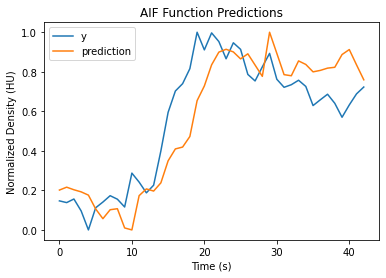

In [68]:
case_number = 60
case_id = ctp_volumes[case_number]['image'].split('.')[-2]
type_predictions = 'AIF'
x = ctp_volumes[case_number]['ctpvals']
if type_predictions == 'AIF':
    y = aif_annotations[case_id]
if type_predictions == 'VOF':
    y = vof_annotations[case_id]
print(case_id)
plot_predictions(model,x,y,normalize_preds=True, type_pred=type_predictions)